1 -  Faça uma análise descritiva em cima dos documentos. 
O que você conclui apenas olhando para eles? 
Qual a forma de escrita dos documentos? Há tipos diferentes? 
Olhando os textos consegue identificar alguma alteração comum entre os pacientes? 

In [6]:
#pip install html2text
#pip install unidecode
#pip install rtf-converter
#pip install wordcloud
#pip install nltk

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple,Union,Literal
from functools import partial
import nltk
from openai import OpenAI
import os
from dotenv import load_dotenv
import json
from sklearn.cluster import AgglomerativeClustering as AGNES
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN
from nltk.corpus import stopwords
from unidecode import unidecode
import html2text
from rtf_converter import rtf_to_txt


load_dotenv()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/estevanmendes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
np.random.seed(42)

In [9]:
path=r'amostra_nlp.csv'

### Preprocessamento

In [10]:
df_raw=pd.read_csv(path)
df_raw.head()

,patient_id,age,sex,ehr_date,text
0,341196,82.0,M,2023-09-05 10:23:37,"<html tasy=""html5""><body><p style=""text-align:..."
1,4309949,32.0,F,2023-11-01 12:10:59,"<html tasy=""html5""><body><p style=""text-align:..."
2,404932,91.0,M,2023-09-16 07:24:02,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
3,5603035,53.0,F,2024-08-03 06:56:48,RET 6 MESES PARA AVALIAÇÃO CALCIO + VIT D
4,154876,27.0,M,2023-11-05 04:58:01,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...


In [11]:
df_raw.tail()

,patient_id,age,sex,ehr_date,text
6829,4888904,40.0,M,2023-11-17 18:23:20,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
6830,395277,38.0,F,2023-09-27 22:15:42,{\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
6831,2086843,61.0,M,2023-11-08 19:19:44,"<html tasy=""html5""><body><p style=""text-align:..."
6832,500002679850091,37.0,F,2020-12-28 00:00:00,"# NOME: BRUNA ALVES PINTO PEREIRA, 32 ANOS, DN..."
6833,-80520,64.0,M,2024-04-30 13:48:39,"<html tasy=""html5""><body><p style=""text-align:..."


In [12]:
df_raw.shape

(6834, 5)

In [13]:
from IPython.display import display
def missing_values_report(df):
    print('Valores ausentes por coluna:')
    display(df.isna().sum())
    print('Valores ausentes por linha:')
    display(df.isna().sum(axis=1).value_counts().reset_index().rename(columns={'index':'Quantidade de valores ausentes',0:'Quantidade de linhas'}))

In [14]:
missing_values_report(df_raw)

Valores ausentes por coluna:


patient_id    0
age           1
sex           0
ehr_date      0
text          0
dtype: int64

Valores ausentes por linha:


,Quantidade de valores ausentes,Quantidade de linhas
0,0,6833
1,1,1


Os valores ausentes, podem ser removidos ou inferidos/inputados. 
Nesse Caso, por se tratar somente de uma instância, e as outras variáveis(exceção do texto, que poderia  conter indícios da idade) serem descorrelacionas com a idade. 

In [15]:
print(df_raw[df_raw.isna().any(axis=1)]['text'].iloc[0])

 paciente  retorna  apos  um ano nos eua - 
  trablahou 6 mese , voltou na faculdade   treinos em maio de futebol 
 nega dor , nega infeccao , 
 covid neg 

 12 /21  ultima  consulta 


 em uso 
-a radois 50mg 1x 


12/21 ac = 6,1 vitd = 25,3 , k = 3,8  crea = 1,33 ureia = 32 hg 14 ht 40,9 leuc  4300 palq 19110000 rotina ndnd rc/p = 0,12 


 peso 78,7 kg seme demas eupenicoa pa 130x80 

 cd lab , oriento 

  peso 78,7 kg , sem edemas 


In [16]:
def drop_missing_values(df:pd.DataFrame,column_threshold=0.6,row_threshold:[int,float]=0.9)->pd.DataFrame:
    filter_columns_to_remove=df.isna().sum()/len(df)>column_threshold
    print('Columns removidas:',df.columns[filter_columns_to_remove])
    if isinstance(row_threshold,float):
        row_threshold=int(row_threshold*df.shape[1])
    
    filter_rows_to_remove=df.isna().sum(axis=1)>=row_threshold
    print('Qtd de linhas removidas:',sum(filter_rows_to_remove))
    df=df.loc[~filter_rows_to_remove,~filter_columns_to_remove]

    return df


In [17]:
df_processed=drop_missing_values(df_raw,column_threshold=0.6,row_threshold=1)

Columns removidas: Index([], dtype='object')
Qtd de linhas removidas: 1


In [18]:
def enforce_types(df,dates:List,discrete:List,categorical:List):
    df[dates]=df[dates].apply(partial(pd.to_datetime,format='%Y-%m-%d %H:%M:%S',errors='ignore'))
    df[discrete]=df[discrete].astype(np.float16).astype(int)
    df[categorical]=df[categorical].astype('category')

    return df

In [19]:
df_processed=enforce_types(df_processed,dates=['ehr_date'],discrete=['age'],categorical=['sex'])

In [20]:
def encode_categorical(df:pd.DataFrame,categorical_columns:List)->pd.DataFrame:
    df[categorical_columns]=df[categorical_columns].apply(lambda x:x.cat.codes)
    return df

def dummy_encode_categorical(df:pd.DataFrame,categorical_columns:List)->pd.DataFrame:
    df=pd.get_dummies(df,columns=categorical_columns)
    return df

In [21]:
def show_range(df,type:Literal['number','datetime','object','category']=None):
    
    if type is None:
        show_range(df,type='number')
        plt.show()
        show_range(df,type='datetime')
        plt.show()
        show_range(df,type='object')
        plt.show()
        show_range(df,type='category')

    elif type=='number':
        df.select_dtypes(include='number').plot(kind='box',subplots=True)
        plt.title('Distribuição dos números')
        plt.tight_layout()

        
    elif type=='datetime':
        df.select_dtypes(include='datetime').value_counts().plot(kind='line',subplots=True)
        plt.xticks(rotation=45)
        plt.title('Distribuição de datas')
        plt.tight_layout()

    elif type=='object':
        df.select_dtypes(include='object').apply(len).plot(kind='box',subplots=True)
        plt.title('Tamanho das strings')
        plt.tight_layout()

    elif type=='category':
        df.select_dtypes(include='category').value_counts().plot(kind='bar',subplots=True)

        plt.title('Distribuição das categorias')
        plt.tight_layout()
        
    else:
        raise ValueError('Tipo não suportado')




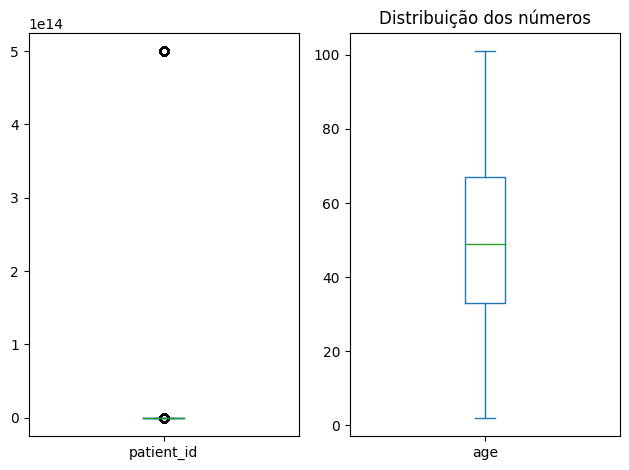

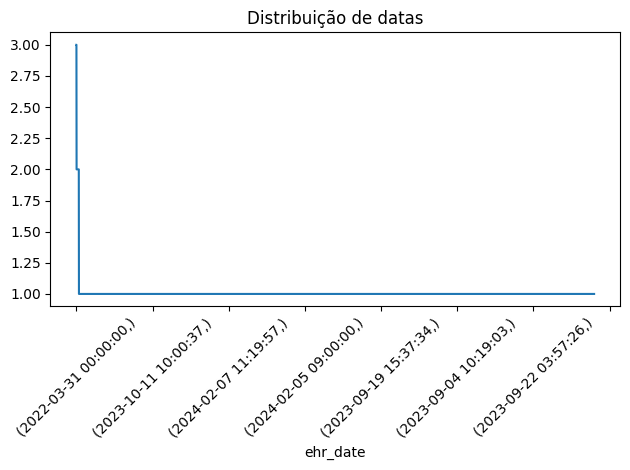

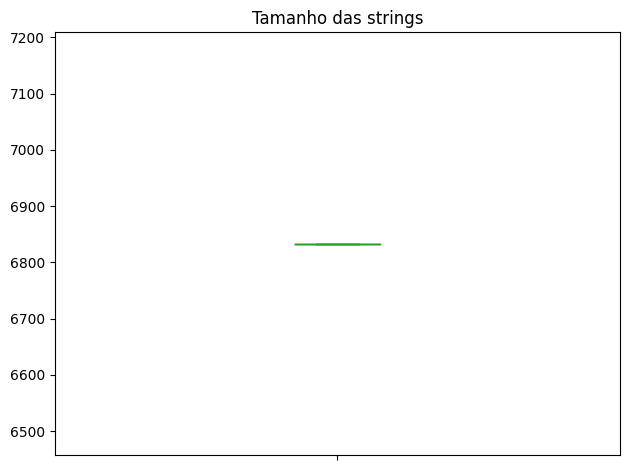

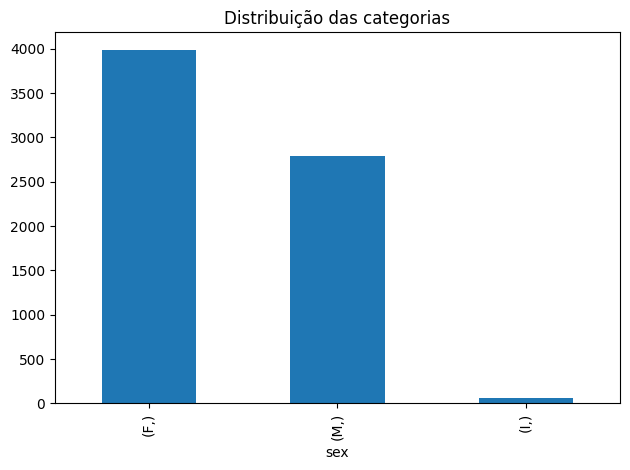

In [22]:
show_range(df_processed)

Os dados, aparentemente, não apresentam outliers. Caso apresentassem outliers, estes poderiam ser removidos utilizando a regra proveniente dos boxplots, isto é, Q1- 1.5*DIQ e Q3+ 1.5*DIQ, ou usando a regra empírica. 

Onde DIQ= Distância interquartilica.

In [23]:
#df_processed=encode_categorical(df_processed,['sex'])

### Data Mininig

In [24]:
df_processed['text'].tail(50)

6784    <html tasy="html5"><body><p style="text-align:...
6785                           DM sem controle; hba1c 7,8
6786    <html tasy="html5"><body><p><span style=""><sp...
6787    Usg Doppler Colorido Tireoide\t\r\nObservações...
6788    <html tasy="html5"><body><p style="text-align:...
6789    {\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
6790    Recomendações Gerais \r\n\r\nFaça das refeiçõe...
6791    QP: Historia recente de colica renal HMA: Info...
6792    {\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
6793    <html tasy="html5"><body><p style="text-align:...
6794    <html tasy="html5"><body><p style="text-align:...
6795    <html tasy="html5"><body><p style="text-align:...
6796    <html tasy="html5"><body><p style="text-align:...
6797    <html tasy="html5"><body><p style="text-align:...
6798    {\rtf1\ansi\ansicpg1252{\fonttbl{\f0\fnil\fcha...
6799    LOCAL: None Pertences entregues a acompanhante...
6800    <html tasy="html5"><body><p style="text-align:...
6801    <html 

Observando a amostra, existem textos nas seguintes formatações:

    - html\\
    - RTF\\
    - Texto puro\\

Abaixo Fica evidenciado os 3 tipos a patir dos diferentes caracteres especiais que existem nos textos. 
Por meio da similaridade, que poderia ser computada pela interseção dos conjuntos, poderia-se identificar os diferentes grupos de texto sem a necessidade de inspeção visual, tal qual foi feito anteriormente. 

In [25]:
df_processed['text'].head(50)\
            .str.lower()\
            .apply(unidecode)\
            .str.replace('[a-z0-9]','',regex=True)\
            .apply(set)

0            {;, /, :, -, =, &, #, ", <, (, >, ,,  , )}
1               {;, /, :, -, =, &, #, ", <, >, ., ,,  }
2             {\n, ;, :, -, ', \, }, {, \r, *, ., ,,  }
3                                                { , +}
4     {_, \, <, *,  , ;, /, ', }, \r, %, ., ,, \n, -...
5               {;, /, :, -, =, &, #, ", <, >, ., ,,  }
6         {;, /, :, -, =, &, #, ", <, (, >, ., ,,  , )}
7      {;, +, /, :, -, =, &, #, ", <, (, >, ., ,,  , )}
8               {;, +, /, :, -, =, &, #, ", <, >, ,,  }
9      {;, /, :, -, =, &, #, ", <, %, (, >, ., ,,  , )}
10     {;, /, :, -, =, &, #, ", <, (, >, ., ,,  , ), _}
11      {\n, ;, :, -, ', \, }, {, \r, (, *, ., ,,  , )}
12    {\n, ;, +, /, :, -, =, &, #, ", <, %, >, ., ,,  }
13                     {\n, ;, -, ', \, }, {, \r, *,  }
14           {;, +, /, :, -, =, &, #, ", <, >, ., ,,  }
15    {\n, ;, +, /, :, -, =, &, #, ", <, %, (, >, .,...
16        {;, /, :, -, =, &, #, ", <, (, >, ., ,,  , )}
17        {;, /, :, -, =, &, #, ", <, (, >, ., ,

In [26]:
def label_text_type(text):
    if 'html' in text:
        return 'html'
    elif '{' in text:
        return 'rtf'
    else:
        return 'plain_text'

    

In [27]:
df_processed['text_type']=df_processed['text'].apply(label_text_type)

<Axes: >

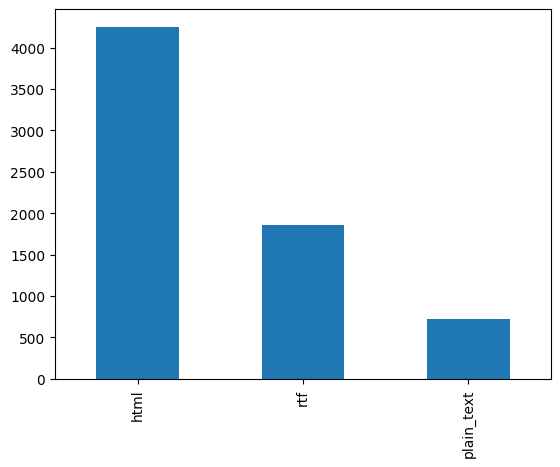

In [28]:
df_processed['text_type'].value_counts().plot(kind='bar')

In [29]:
df_processed['weekday']=df_processed['ehr_date'].dt.weekday

<Axes: xlabel='None-sex', ylabel='weekday'>

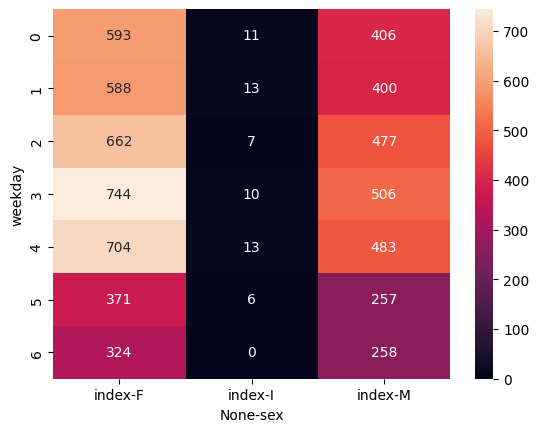

In [30]:
sns.heatmap(df_processed[['weekday','sex']].reset_index().groupby(['weekday','sex']).count()\
        .reset_index()\
        .pivot(columns='sex',index='weekday'),annot=True,fmt='d')

Homens e mulhes não costumam ir ao médico em finais de semana. 


In [31]:
def age_discretizate(age:int)->str:
    if age<=10:
        return 'crianca'
    elif age<=20:
        return 'adolescente'
    elif age<=30:
        return 'jovem'
    elif age<=40:
        return 'adulto'
    elif age<=50:
        return 'meia-idade'
    else:
        return 'idoso'



In [32]:
df_processed['age_group']=df_processed['age'].apply(age_discretizate)

In [33]:
df_processed['age_group']=pd.Categorical(df_processed['age_group'],categories=['crianca','adolescente','jovem','adulto','meia-idade','idoso'],ordered=True)

<Axes: xlabel='None-age_group', ylabel='weekday'>

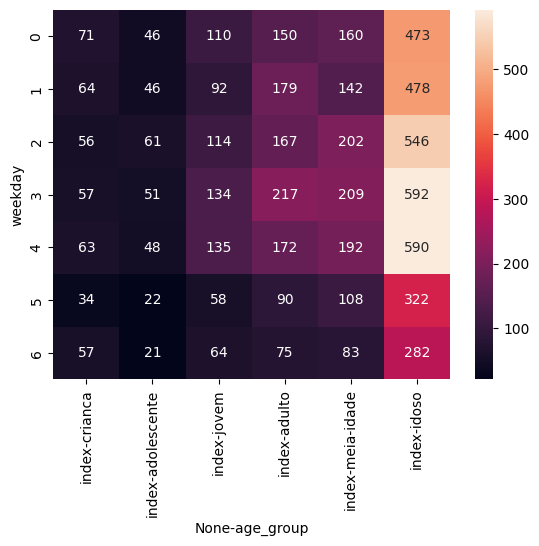

In [34]:
sns.heatmap(df_processed[['weekday','age_group']].reset_index().groupby(['weekday','age_group']).count()\
        .reset_index()\
        .pivot(columns='age_group',index='weekday'),annot=True,fmt='d')

A partir dos dados observa-se que Crianças costumam ir a qualquer dia da semana, enquanto idosos e adultos apresentam uma preferencia pelos dias: 2,3,4,5

<Axes: xlabel='None-sex', ylabel='age_group'>

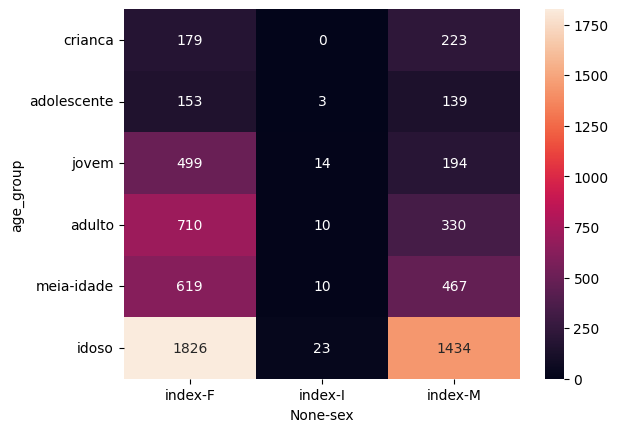

In [35]:
sns.heatmap(df_processed[['sex','age_group']].reset_index().groupby(['sex','age_group']).count()\
        .reset_index()\
        .pivot(columns='sex',index='age_group'),annot=True,fmt='d')

No grupo das crianças e dos adolescente é possível ver um comportamente diferente, pois existe algum balanceamento entre a faixa etária e o sexo. 
Os idosos também apresentam uma proporção diferente. 
O dataset conta com muito mais mulheres jovens, adultas e de meia idade.


A partir dos dados, uma inferência possível, assumindo uma coleta sem viéses, é de que as mulheres jovens, adultas e de meia idade procuram mais os médicos que os homens.

<Axes: xlabel='None-sex', ylabel='weekday'>

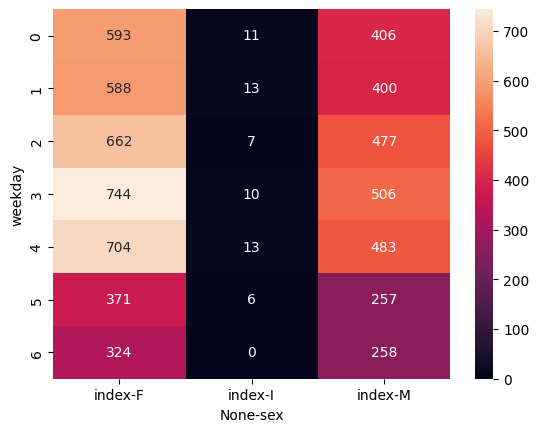

In [36]:
sns.heatmap(df_processed[['weekday','sex']].reset_index().groupby(['weekday','sex']).count()\
        .reset_index()\
        .pivot(columns='sex',index='weekday'),annot=True,fmt='d')

In [37]:
df_processed['plain_text']=df_processed['text']
filter_html=df_processed['text_type']=='html'
df_processed.loc[filter_html,'plain_text']=df_processed[filter_html]['text'].apply(html2text.html2text)

In [38]:
filter_rtf=df_processed['text_type']=='rtf'
df_processed.loc[filter_rtf,'plain_text']=df_processed[filter_rtf]['text'].apply(rtf_to_txt)

In [39]:
def preproces_text_column(df,column):
    """
    Minusculas, sem acentos, sem caracteres especiais
    """
    df[column]=df[column].str.lower()\
                        .apply(unidecode)\
                        .str.replace('[^a-z0-9 \n]+','',regex=True)
                        
    return df

In [40]:
df_processed['plain_text'].head(50).iloc[0]

'**ANAMNESE - CENTRO CLÍNICO**\n\nQueixa Principal: DOR INGUINOESCROTAL ESQ A/E\n\nAlergias: Nega Alergia à Medicamentos\n\nHDA:\n\nHPP:\n\nSinais Vitais\n\n **PA:** X **FC:** **FR:** **T:** **Dor:**\n\nExame Físico:\n\nHipótese Diagnóstica:HERNIA INGUINAL\n\nConduta:EXAMES\n\n\u200b\n\n'

In [41]:
df_processed=preproces_text_column(df_processed,'plain_text')

In [42]:
df_processed['plain_text'].head(50).iloc[0]

'anamnese  centro clinico\n\nqueixa principal dor inguinoescrotal esq ae\n\nalergias nega alergia a medicamentos\n\nhda\n\nhpp\n\nsinais vitais\n\n pa x fc fr t dor\n\nexame fisico\n\nhipotese diagnosticahernia inguinal\n\ncondutaexames\n\n \n\n'

### Agrupamento de textos

In [43]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords=[unidecode(word) for word in stopwords]

In [44]:
tfid_vectorizer=TfidfVectorizer(max_features=50,stop_words=stopwords)
X_tfidf=tfid_vectorizer.fit_transform(df_processed['plain_text'])

In [45]:
count_vectorizer=CountVectorizer(max_features=50,stop_words=stopwords)
X_cvec=count_vectorizer.fit_transform(df_processed['plain_text'])

In [46]:
def run_kmeans(X,min_clusters:int=2,max_clusters:int=10,step:int=1)->List:
    inertia=[]
    for i in range(min_clusters,max_clusters,step):
        kmeans=KMeans(n_clusters=i,n_init='auto')
        kmeans.fit(X)
        inertia.append({'inertia':kmeans.inertia_,'n_clusters':i})
    return inertia

def plot_elbow(inertia_dict:List):
    inertias=[x['inertia'] for x in inertia_dict]
    n_clusters=[x['n_clusters'] for x in inertia_dict]
    plt.subplot(121)
    plt.plot(n_clusters,inertias)
    plt.title('Elbow Method')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inertia')
    plt.subplot(122)
    plt.plot(n_clusters[1:],np.diff(inertias))
    plt.show()

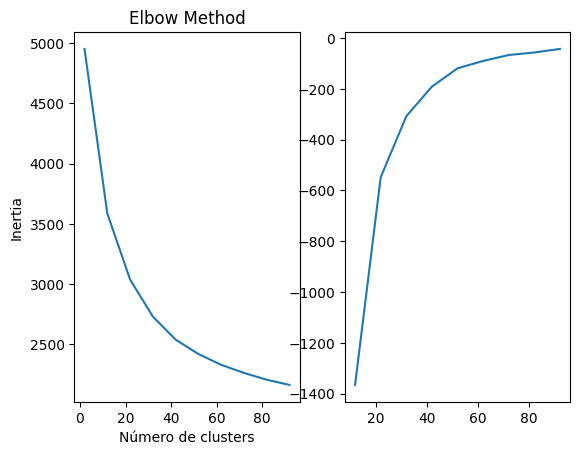

In [47]:
inertia=run_kmeans(X_tfidf,min_clusters=2,max_clusters=100,step=10)
plot_elbow(inertia)

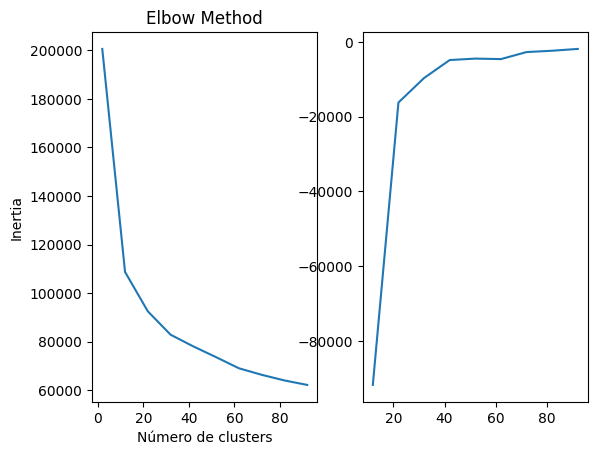

In [48]:
inertia=run_kmeans(X_cvec,min_clusters=2,max_clusters=100,step=10)
plot_elbow(inertia)

In [50]:
cluster_topic=KMeans(n_clusters=10)
cluster_topic.fit(X_cvec)

/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [51]:
df_processed['cluster_topic']=cluster_topic.predict(X_cvec)

<Axes: >

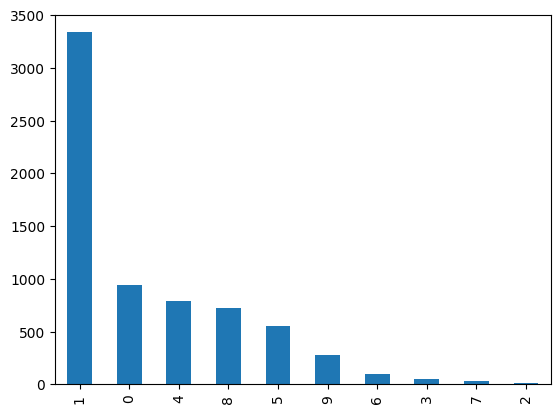

In [52]:
df_processed['cluster_topic'].value_counts().plot(kind='bar')

In [53]:
def remove_stopwords(text:str,stopwords:List)->str:
    return ' '.join([word for word in text.split() if word not in stopwords])

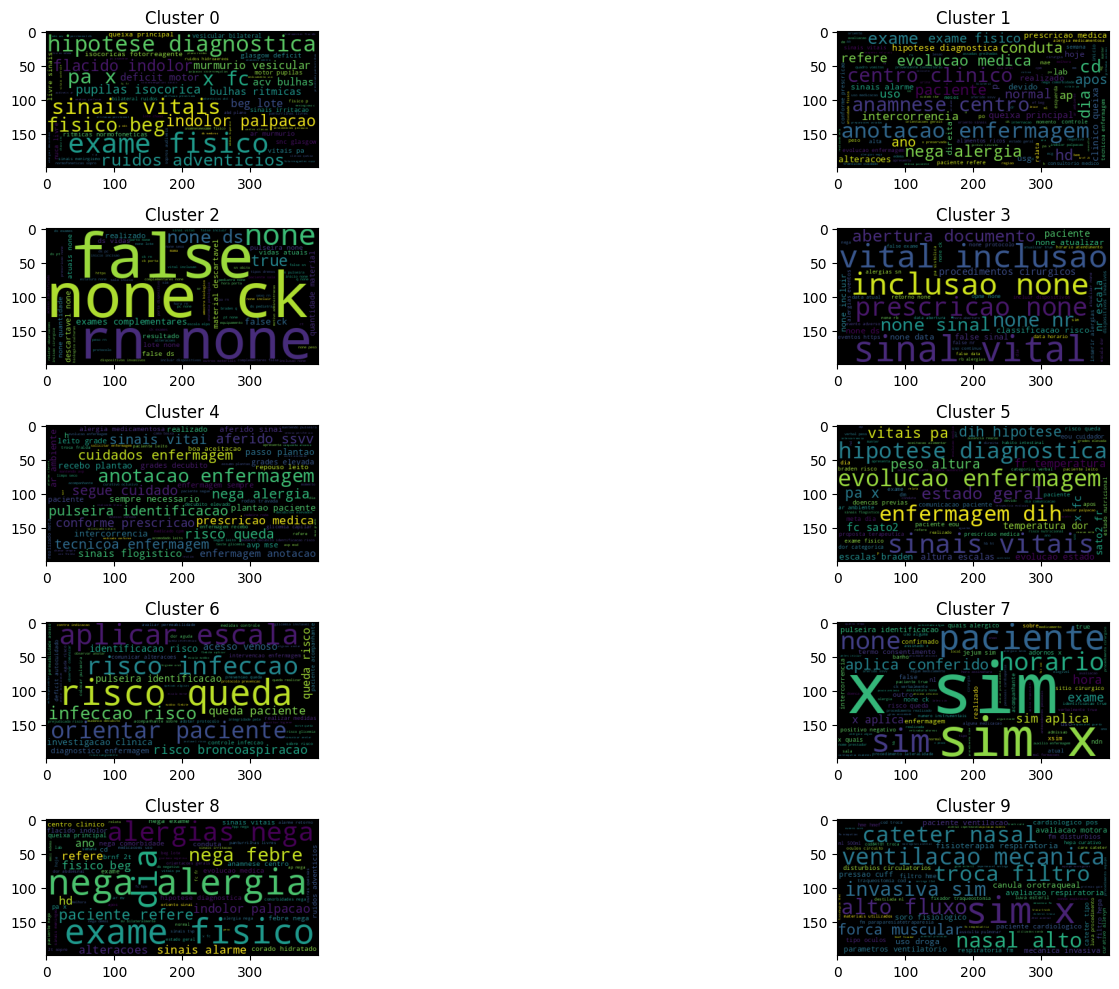

In [54]:
plt.subplots(5,2,figsize=(20,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    text=' '.join(df_processed['plain_text'][df_processed['cluster_topic']==i].to_list())
    text=remove_stopwords(text,stopwords)
    wc = WordCloud().generate(text)
    plt.imshow(wc)
    plt.title(f'Cluster {i}')
plt.tight_layout()

Em relação às nuvens de Palavras dos 10 grupos:


Grupo 1 e 4: apresentam informações sobre as anotações de enfermagem, porém, o grupo um dispõe também da anamnese. 


Grupo 6: aparenta estar associados à riscos. 


Grupo 2: textos sem valor, que apresentam informações vazias. 


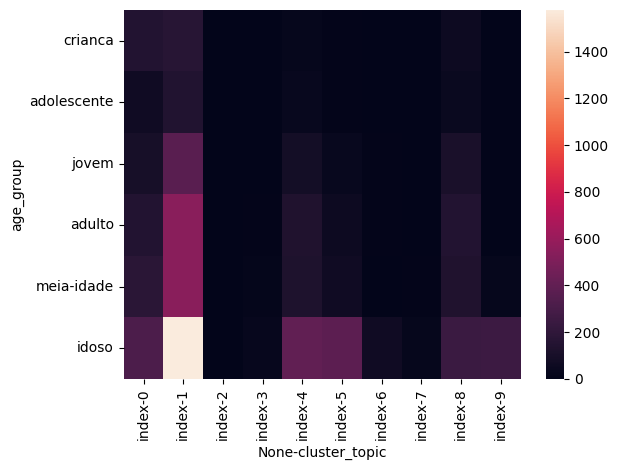

In [55]:
sns.heatmap(df_processed[['cluster_topic','age_group']].reset_index().groupby(['cluster_topic','age_group']).count()\
        .reset_index()\
        .pivot(columns='cluster_topic',index='age_group'),annot=False,fmt='d')
plt.tight_layout()

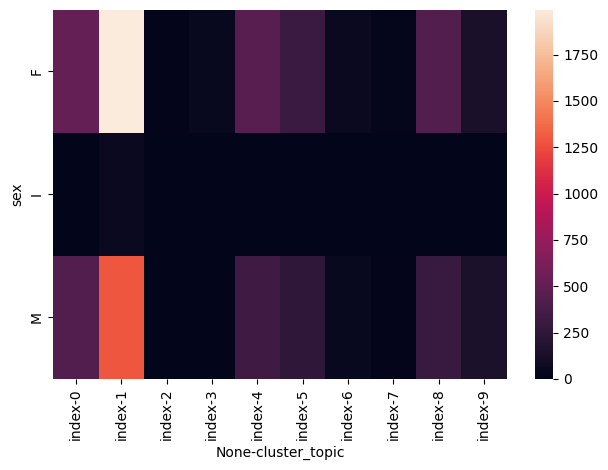

In [56]:
sns.heatmap(df_processed[['cluster_topic','sex']].reset_index().groupby(['cluster_topic','sex']).count()\
        .reset_index()\
        .pivot(columns='cluster_topic',index='sex'),annot=False,fmt='d')
plt.tight_layout()

In [57]:

def run_dbscan(X,min_samples:int=10,eps:float=0.5)->List:
    dbscan=DBSCAN(min_samples=min_samples,eps=eps)
    dbscan.fit(X)
    return dbscan.labels_
def run_range_db_scan(X,min_samples_range,eps:float=0.5)->List:
    records=[]
    for min_samples in min_samples_range:
        labels=run_dbscan(X,min_samples=min_samples,eps=eps)
        if len(np.unique(labels))>1:
            sc_score=silhouette_score(X,labels)
        else:
            sc_score=None
        records.append({'min_samples':min_samples,'silhouette_score':sc_score,'clusters':len(np.unique(labels))})
    return records

def plot_dbscan(labels:List):
    silhouette_scores=[x['silhouette_score'] for x in labels]
    min_samples=[x['min_samples'] for x in labels]
    clusters=[x['clusters'] for x in labels]
    plt.subplot(121)
    plt.plot(min_samples,silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score')
    plt.subplot(122)
    plt.plot(min_samples,clusters)
    plt.title('Número de clusters')
    plt.xlabel('Min Samples')
    plt.ylabel('Número de clusters')
    plt.show()
    plt.tight_layout()

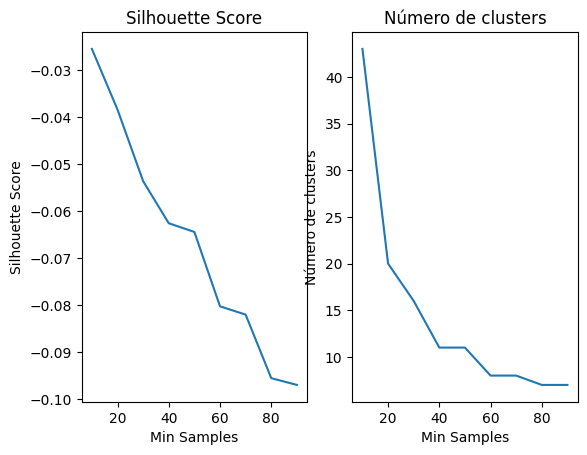

<Figure size 640x480 with 0 Axes>

In [58]:
dbscan_clusters=run_range_db_scan(X_tfidf,min_samples_range=range(10,100,10),eps=0.5)
plot_dbscan(dbscan_clusters)

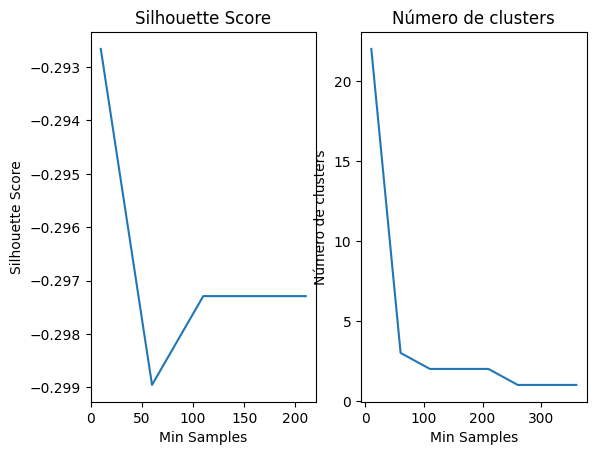

<Figure size 640x480 with 0 Axes>

In [59]:
dbscan_clusters=run_range_db_scan(X_cvec,min_samples_range=range(10,400,50),eps=0.5)
plot_dbscan(dbscan_clusters)

Dado que a abordagem com agrupamento por densidade não se saiu bem nos experimentos, uma abordagem com redução de dimensionalidade será empregada. Em que os embeddings passaram pelo PCA antes de serem agrupados.

In [60]:
pca=PCA(n_components=7)
pca.fit(X_cvec.toarray())
pca.explained_variance_ratio_

array([0.38208914, 0.12379857, 0.07320031, 0.06220036, 0.03615106,
       0.03091779, 0.02615876])

In [61]:
X_pca=pca.transform(X_cvec.toarray())

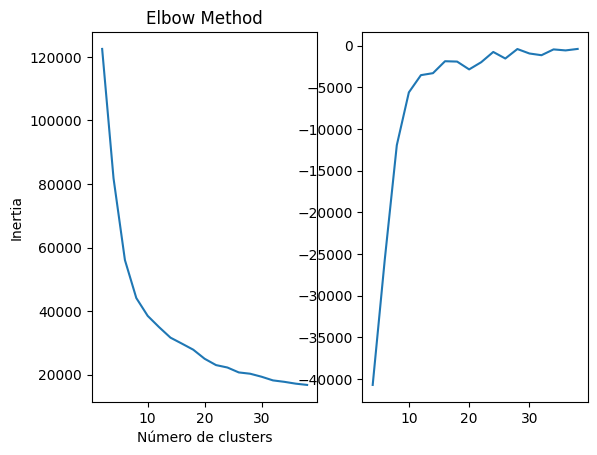

In [62]:
kmeans_data=run_kmeans(X_pca,min_clusters=2,max_clusters=40,step=2)
plot_elbow(kmeans_data)

Tomemos o melhor modelo de clusterização para gerar agrupamentos para os textos.

In [63]:
KMeans_pca=KMeans(n_clusters=10)
KMeans_pca.fit(X_pca)


/home/estevanmendes/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [64]:
df_processed['cluster_pca_topic']=KMeans_pca.predict(X_pca)

Por meio da inspeção das núvems de palavras será possível observar os diferentes topicos 

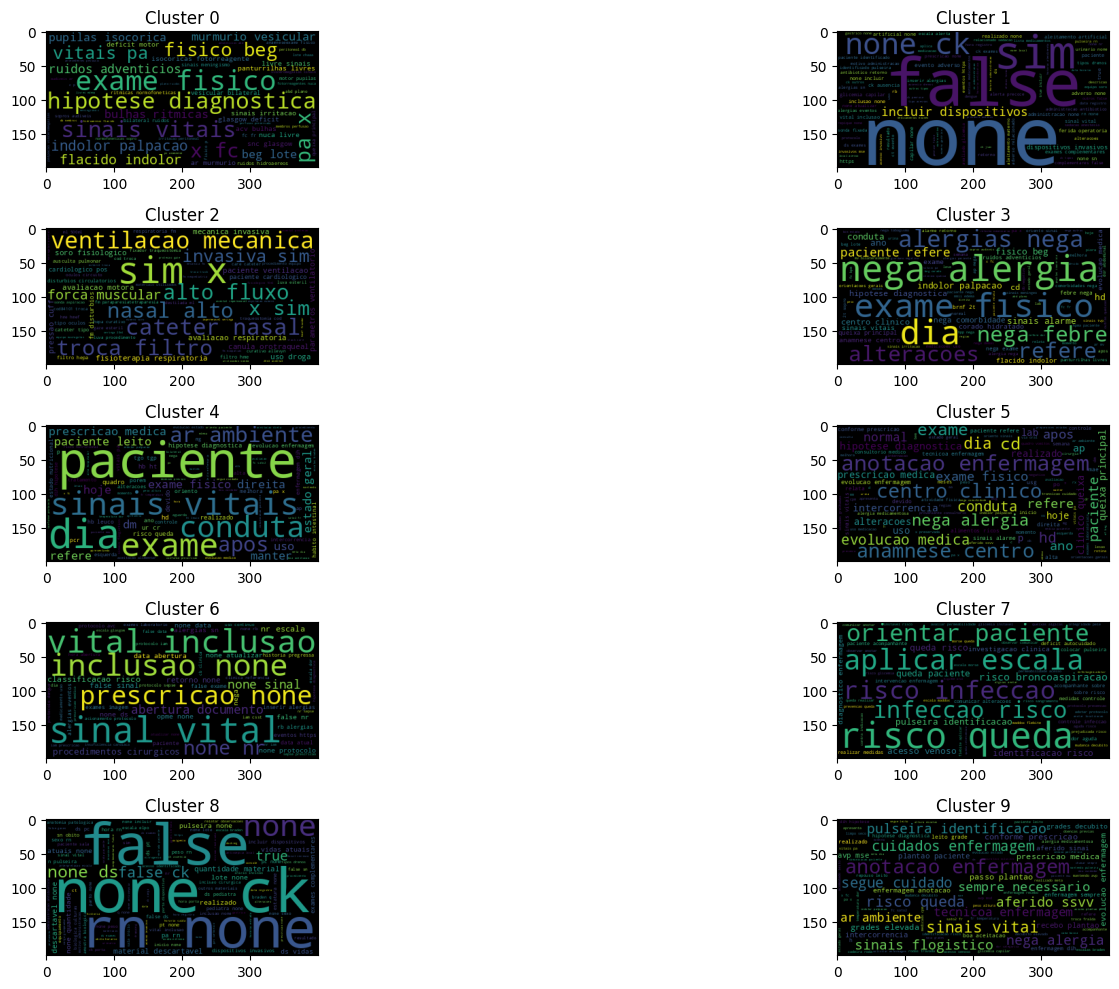

In [65]:
plt.subplots(5,2,figsize=(20,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    text=' '.join(df_processed['plain_text'][df_processed['cluster_pca_topic']==i].to_list())
    text=remove_stopwords(text,stopwords)
    wc = WordCloud().generate(text)
    plt.imshow(wc)
    plt.title(f'Cluster {i}')
plt.tight_layout()

Em relação aos tópicos/grupos: 

Grupo 7: apresenta informações sobre orientações dadas aos pacientes sobre riscos, por exemplo, o de queda. 

Grupo 6 e 4: aparentemente, os grupos se referem a informações sobre os sinais vitais dos pacientes.

Grupo 8: detém os textos sem valor, e com informações muito diversas. 

In [66]:
def run_agnes(X,min_clusters:int=2,max_clusters:int=10,step:int=1)->List:
    metrics=[]
    for i in range(min_clusters,max_clusters,step):
        model=AGNES(n_clusters=i)
        model.fit(X)
        sc_score=silhouette_score(X,model.labels_)
        metrics.append({'silhouette_score':sc_score,'n_clusters':i})
    return metrics

def plot_agnes(labels:List):
    silhouette_scores=[x['silhouette_score'] for x in labels]
    n_clusters=[x['n_clusters'] for x in labels]
    plt.plot(n_clusters,silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


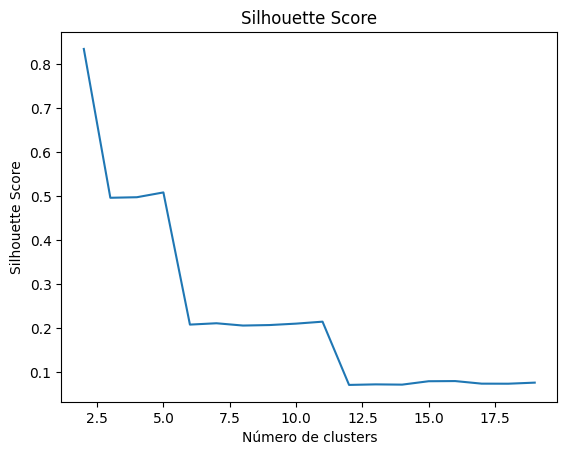

In [67]:
agnes_metrics=run_agnes(X_cvec.toarray(),min_clusters=2,max_clusters=20,step=1)
plot_agnes(agnes_metrics)

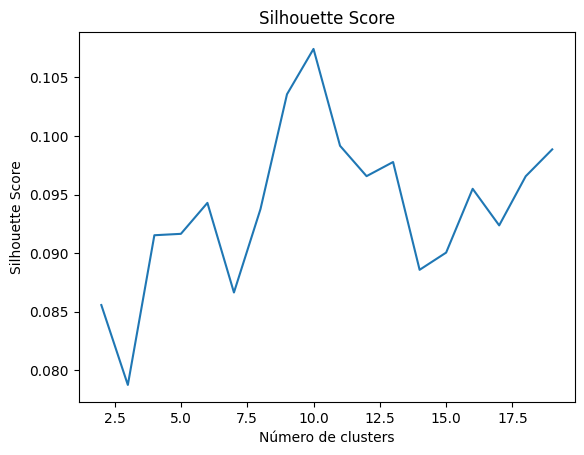

In [68]:
agnes_metrics=run_agnes(X_tfidf.toarray(),min_clusters=2,max_clusters=20,step=1)
plot_agnes(agnes_metrics)

Em razão dos resultados também insatisfatórios gerados com agrupamento hierárquico, assim, como no caso por densidade, estes grupos não serão explorados. 

### Teste openAI

Outras técnicas de embedding que levam em consideração a semântica, diferentemente da abordagem morfológica empregada acima, podem ser exploradas. 
Por exemplo, o embedding gerado pelo BertimBau, ou mesmo os embeddings gerados pelos LLMs[1], como o GPT4omini que dispõe de um excelente custo em relação aos demais modelos. 
Por último,é possível utilizar Latent Semantic Idenxing para extração de tópicos e agrupamento dos textos.

[1] Freestone, Matthew, and Shubhra Kanti Karmaker Santu. "Word Embeddings Revisited: Do LLMs Offer Something New?." arXiv preprint arXiv:2402.11094 (2024).

Afim de explorarmos a utilização dos LLMs, abaixo será empregado o GPT4o-mini para obtenção dos tópicos 

In [69]:

def openai_chat(prompt,text,model="gpt-4o-mini-2024-07-18")->str:
    api_key=os.getenv('OPENAI_API_KEY')
    client=OpenAI(api_key=api_key)
    messages=[
              {
                "role": "system",
                "content": [
                  {
                    "type": "text",
                    "text": prompt
                  }
                ]
              },
              {
                "role": "user",
                "content": [
                  {
                    "type": "text",
                    "text": text
                  }
                ]
              }
            ]

    response=client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens=1002,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        response_format={
            "type": "json_object"
        }
    )
    content=response.choices[0].message.content
    return content


In [70]:
#df_processed['plain_text'].to_csv('plain_text.csv',index=False)

In [71]:
prompt="""Sabendo que o texto a seguir é de origem médica realize as seguintes etapas:
        1- analise o texto, 
        2 - sintetize o texto em 3 tópicos, ou palavras chaves
        3- retorne um json da seguinte forma:{"topicos":["topic1","topic2","topic3"]}
        4- caso o texto seja ruidoso e não apresente informações claras e objetivas, retorne um json vazio {"topicos":["","",""]}"""    

Exemplo

In [72]:

openai_chat(prompt,df_processed['plain_text'].iloc[0])

'{"topicos":["dor inguinoescrotal","hipótese diagnóstica: hernia inguinal","exames"]}'

Para expor o comportamento dos LLMs de maneira mais sistemática, vamos avaliar o resultado para as 100 linhas

In [73]:
df_processed_100=df_processed.sample(100)


In [74]:
df_processed_100['topicos_gpt4omini']=df_processed_100['plain_text'].apply(lambda x:openai_chat(prompt,x))

In [75]:
df_processed_100['topic_1']=df_processed_100['topicos_gpt4omini'].apply(lambda x: json.loads(x)['topicos'][0])
df_processed_100['topic_2']=df_processed_100['topicos_gpt4omini'].apply(lambda x: json.loads(x)['topicos'][1])
df_processed_100['topic_3']=df_processed_100['topicos_gpt4omini'].apply(lambda x: json.loads(x)['topicos'][2])

Text(0.5, 1.0, 'Top 20 topicos 1')

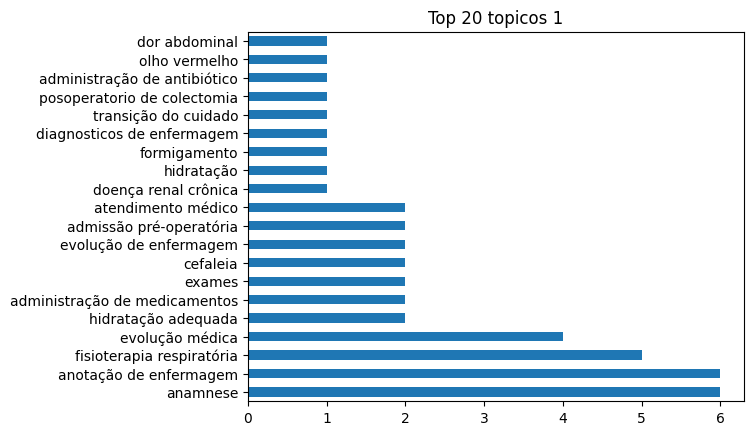

In [76]:
df_processed_100['topic_1'].value_counts().nlargest(20).plot(kind='barh')
plt.title('Top 20 topicos 1')

Text(0.5, 1.0, 'Top 20 topicos 2')

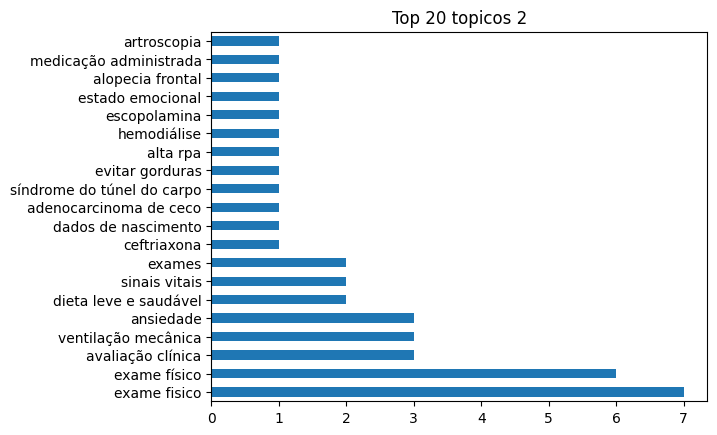

In [77]:
df_processed_100['topic_2'].value_counts().nlargest(20).plot(kind='barh')
plt.title('Top 20 topicos 2')

Text(0.5, 1.0, 'Top 20 topicos 3')

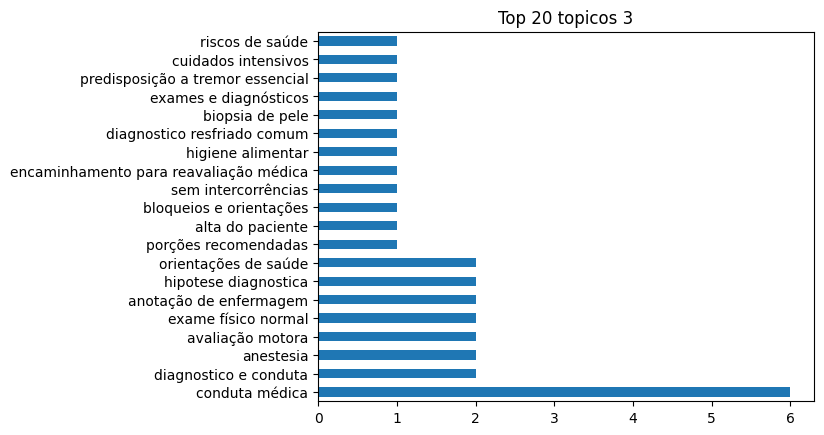

In [78]:
df_processed_100['topic_3'].value_counts().nlargest(20).plot(kind='barh')
plt.title('Top 20 topicos 3')

É possivel observar palavras com semâtica bem parecida se repetindo, estas poderiam ser agrupadas por lemmatização do similaridade de coseno afim de se observar grupos entre os tópicos. 

In [79]:
df_processed.to_csv('df_processed.csv',index=False)

In [80]:
df_processed_100.to_csv('df_processed_sample_size_100.csv',index=False)